# Convolutions and Kernels

## Data Augmentation

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
doc(get_transforms)

Use transformations wisely, depending on the data.

* reflections (padding) works better in most cases

In [0]:
bs = 64
path = untar_data(URLs.PETS)/'images'

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

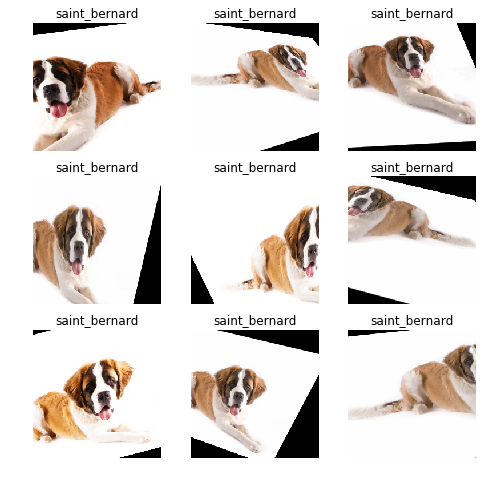

In [45]:
def _plot(i,j,ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224, bs)

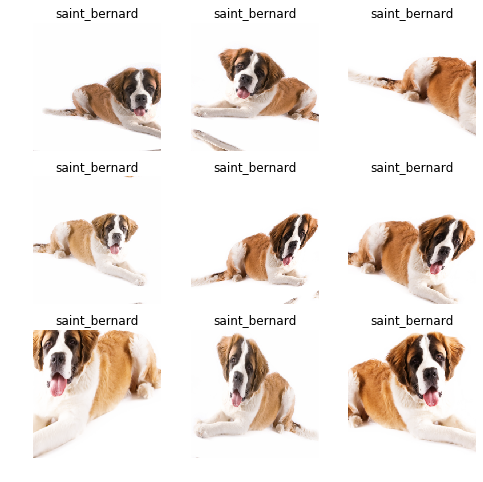

In [47]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [29]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Siamese,wheaten_terrier,saint_bernard,Birman
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
newfoundland,great_pyrenees,miniature_pinscher,miniature_pinscher,Abyssinian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

## *Training*

* Using resnet34

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


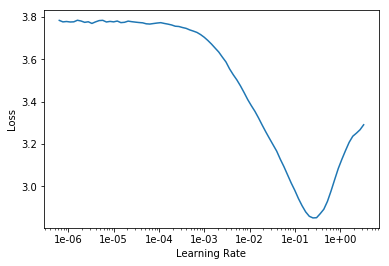

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.308835,1.059744,0.250338,01:22
1,1.341733,0.374047,0.101489,01:21
2,0.839918,0.291288,0.084574,01:20


In [0]:
learn.save('phase-1')

In [0]:
learn.load('phase-1');

In [0]:
learn.unfreeze() # Use unfreeze whenever we want the layers to be trainable again

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


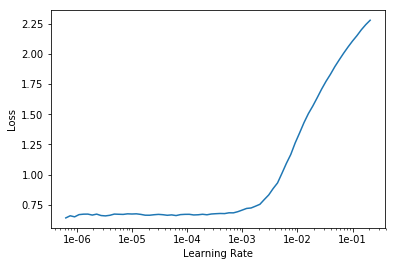

In [53]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(2, max_lr=slice(1e-04,1e-2/5), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.745683,0.496205,0.129905,01:25
1,0.806681,0.404330,0.108931,01:24


In [0]:
learn.save('phase-2')

Increase the size,

In [0]:
data = get_data(352,bs)
learn.data = data

In [61]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.746144,0.337958,0.079161,02:28
1,0.668097,0.329470,0.070365,02:26


In [0]:
learn.save('352')

## Kernels

- http://setosa.io/ev/image-kernels/
- A convolutional kernel or filter
- At the edge, we can pad the image; or else we get a black edge
- We can pad with 0s along the border to give the same dimension output that we stated with
- We can use reflection padding as well
- A convolution is just a matrix multiplication with tied weights
- Tied weights refer to the fixed weights in the kernels/filter
-  Each layer is a convolution; output of one convolution is a channel
- We increase the number of channels as we go deeper into the network
- To avoid our memory going out of control, we use a larger stride i.e. >1
- Stride is the amount by which we slide over the inputs
- We can have a stride of 2 and increase the number of filters like 16 to 32
- We often use larger kernels for the first layer (?)

In [0]:
data = get_data(352, 16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)
learn.load('352');

Category newfoundland

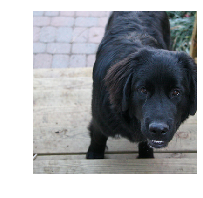

In [67]:
idx = 0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

We can also define our manual convolutional kernels. Here lets define a kernel to detect bottom-right 

In [0]:
k = tensor([
          [0., -5/3, 1],
          [-5/3, -5/3,1],
          [1., 1, 1]  
]).expand(1,3,3,3)/6

`.expand()` copies it for three channels. The 1 indicates one 4-d tensor.

In [69]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [70]:
k.size()

torch.Size([1, 3, 3, 3])

In [71]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [72]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

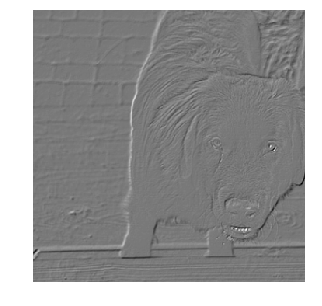

In [74]:
show_image(edge[0], figsize=(5,5));

In [75]:
data.c

37

In [76]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [77]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

> Notes :
- Here **BatchNorm2d [512, 11, 11** would be the last convolutional layer.
- We need 37 dimensional vector for getting the final probabilities
- Hence in AvgPooling we tend to average each 11x11 matrix and get a 512 dimensional vector
- We use this vector as the input to a fully connected layer and get a 37 dimensional output 
- We can also average across the channel i.e the depth of 512, which would give us the average activations along all the channels
- We would get a 11x11 matrix
- We can use _hook to tell PyTorch to store things for us

## Heatmap

In [0]:
m = learn.model.eval()

In [82]:
m[0] # This pretrained/convolutional bit, is always indexed 0

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [0]:
xb, _ = data.one_item(x) # mini-batch of 1 item
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

We want to grab m[0] and hook its output. We also use **Context manager** in python to remove hooks at the end and not keep storing it all the time.

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

To get the activations themselves,

In [86]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

And we got the tensor of size [512, 11, 11] as expected. Now we take the mean along the 512 channels to get 11x11 2-d tensor of the average activations,

In [87]:
avg_acts = acts.mean(0) # we
avg_acts.shape

torch.Size([11, 11])

Defining our heatmap function as follows,

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

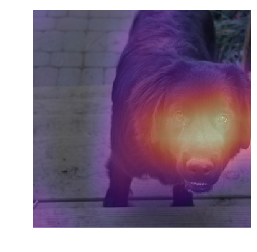

In [90]:
show_heatmap(avg_acts)

> The heatmap gives the areas that were most activated when deciding what class this image belonged.

Follow up with the Grad-CAM paper (https://arxiv.org/abs/1610.02391)